# **Data Loading and Preprocessing**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

train_data_path = r"C:\Users\Advaitha\Desktop\projects\GENOME\newmodel\GSE85047.csv"
test_data_path = r"C:\Users\Advaitha\Desktop\projects\GENOME\newmodel\test_GSE85047.csv"

train_df = pd.read_csv(train_data_path).drop(columns=['geo_id', 'sequence_id'], errors='ignore')
test_df = pd.read_csv(test_data_path).drop(columns=['geo_id', 'sequence_id'], errors='ignore')

clinical_features = ['age_at_diagnosis_days', 'mycn_amplification', 'event_free_survival',
                     'event_free_survival_days', 'inss_stage_2', 'inss_stage_3',
                     'inss_stage_4', 'inss_stage_4S']
gene_columns = [col for col in train_df.columns if col not in clinical_features]

train_clinical, train_genes = train_df[clinical_features], train_df[gene_columns]
test_clinical, test_genes = test_df[clinical_features], test_df[gene_columns]
train_labels, test_labels = train_df['event_free_survival'], test_df['event_free_survival']

scaler = StandardScaler()
train_genes_scaled = scaler.fit_transform(train_genes)
test_genes_scaled = scaler.transform(test_genes)

train_preprocessed = pd.concat([train_clinical, pd.DataFrame(train_genes_scaled, columns=train_genes.columns), train_labels], axis=1)
test_preprocessed = pd.concat([test_clinical, pd.DataFrame(test_genes_scaled, columns=test_genes.columns), test_labels], axis=1)

In [2]:
print("Training Data:")
print(train_df.head())

Training Data:
   age_at_diagnosis_days  mycn_amplification  event_free_survival  \
0                   7100                   0                    0   
1                    196                   0                    0   
2                    447                   1                    1   
3                      5                   0                    1   
4                    900                   0                    0   

   event_free_survival_days  inss_stage_2  inss_stage_3  inss_stage_4  \
0                      1357             0             1             0   
1                      2313             1             0             0   
2                      1198             0             0             1   
3                        67             1             0             0   
4                      2461             0             0             1   

   inss_stage_4S      BCAN    FLVCR1  ...    HAPLN4      TOX2      HRH3  \
0              0 -0.947390  0.180232  ... -0.609558  0.2

In [41]:
print("Test Data:")
print(test_df.head())

Test Data:
       geo_id               sequence_id  age_at_diagnosis_days  \
0  GSM2256846  primary NB tumor_nrc0002                   7100   
1  GSM2256847  primary NB tumor_nrc0003                    196   
2  GSM2256848  primary NB tumor_nrc0004                    447   
3  GSM2256849  primary NB tumor_nrc0005                      5   
4  GSM2256850  primary NB tumor_nrc0006                    900   

   mycn_amplification  event_free_survival  event_free_survival_days  \
0                   0                    0                      1357   
1                   0                    0                      2313   
2                   1                    1                      1198   
3                   0                    1                        67   
4                   0                    0                      2461   

   inss_stage_2  inss_stage_3  inss_stage_4  inss_stage_4S  ...  ZFR2  HYPK  \
0             0             1             0              0  ...     0     0   
1

In [3]:
print("Training Data Shape:")
print(train_df.shape)


print("Test Data Shape:")
print(test_df.shape)

Training Data Shape:
(272, 61)
Test Data Shape:
(272, 140)


# **EDA**

In [4]:
gene_columns_2 = [col for col in train_df.columns if col not in clinical_features + ['geo_id', 'sequence_id']]
train_clinical_df = train_df[clinical_features]
train_genes_df = train_df[gene_columns_2]

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histograms(data, columns, titles, palette="coolwarm"):
    plt.figure(figsize=(16, 10))
    for i, col in enumerate(columns):
        plt.subplot(2, 2, i+1)
        sns.histplot(data[col], kde=True)
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

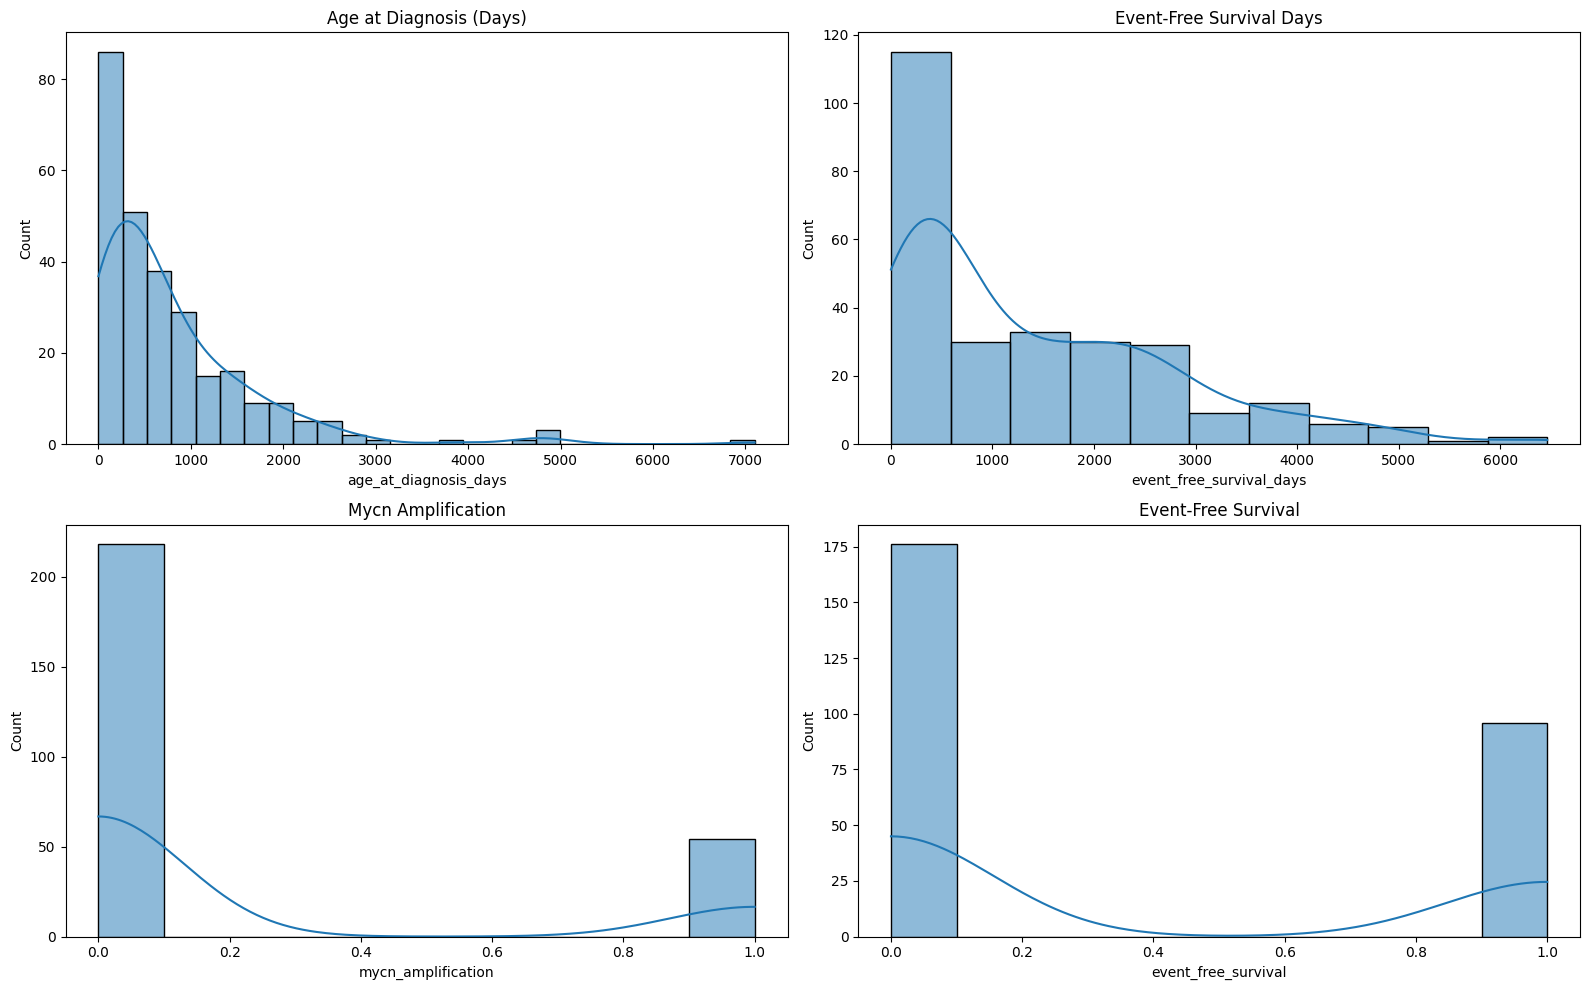

In [6]:
# Plot for Clinical Data Distribution
plot_histograms(train_clinical, ['age_at_diagnosis_days', 'event_free_survival_days', 'mycn_amplification', 'event_free_survival'],
                ['Age at Diagnosis (Days)', 'Event-Free Survival Days', 'Mycn Amplification', 'Event-Free Survival'])

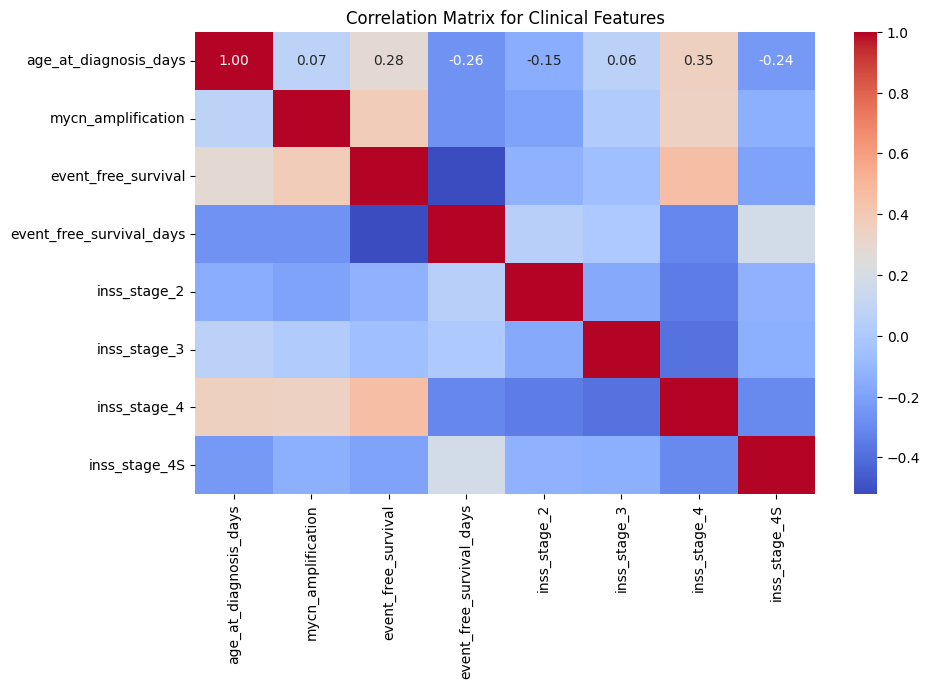

In [7]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(train_clinical.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for Clinical Features")
plt.show()

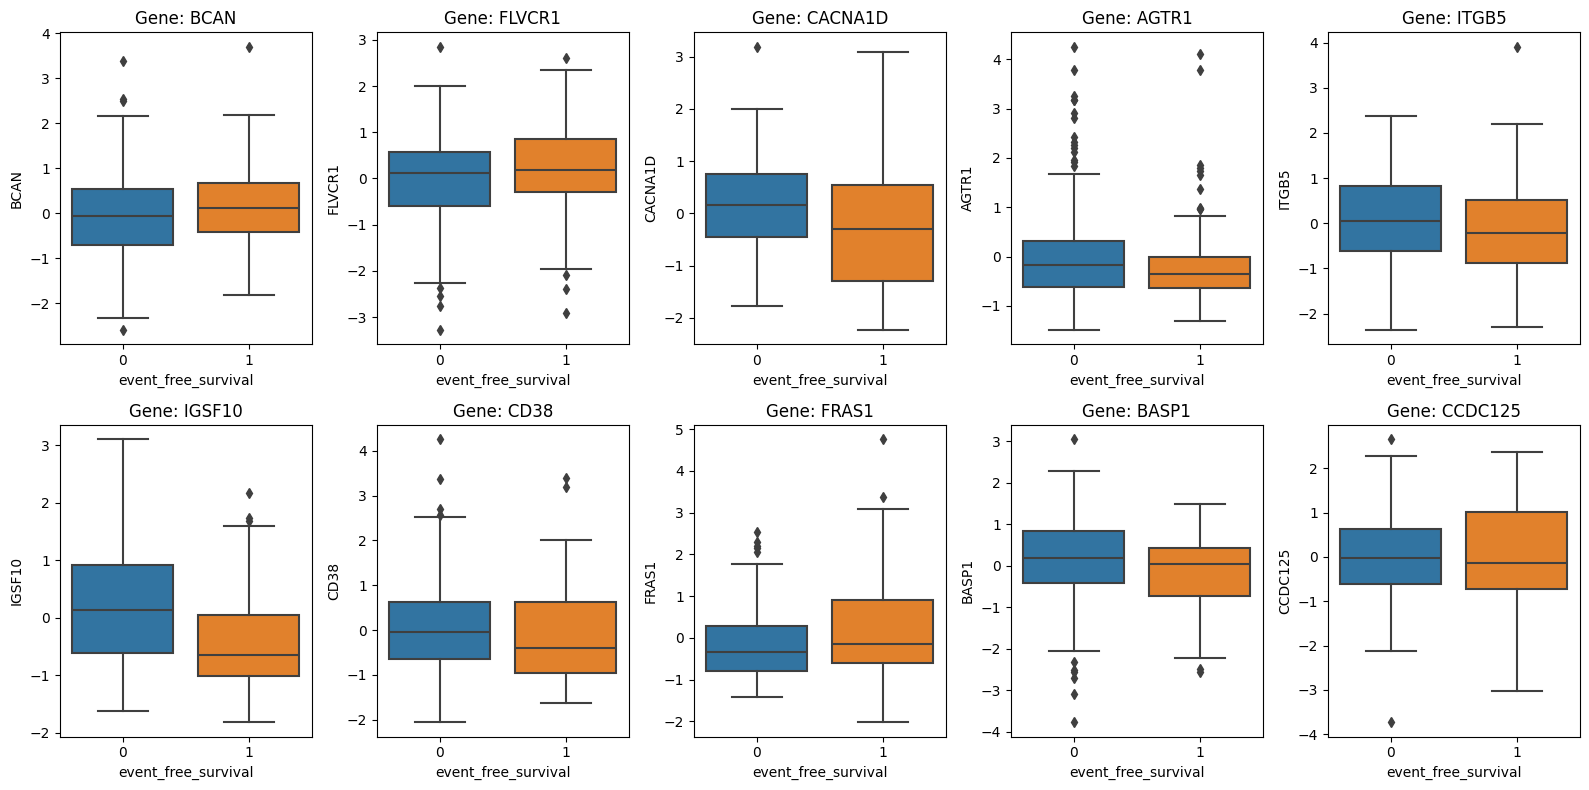

In [8]:
# Boxplot
top_genes = train_genes.columns[:10]  # First 10 genes only
plt.figure(figsize=(16, 8))
for i, gene in enumerate(top_genes):
    plt.subplot(2, 5, i+1)
    sns.boxplot(x=train_labels, y=train_genes[gene])
    plt.title(f'Gene: {gene}')
plt.tight_layout()
plt.show()

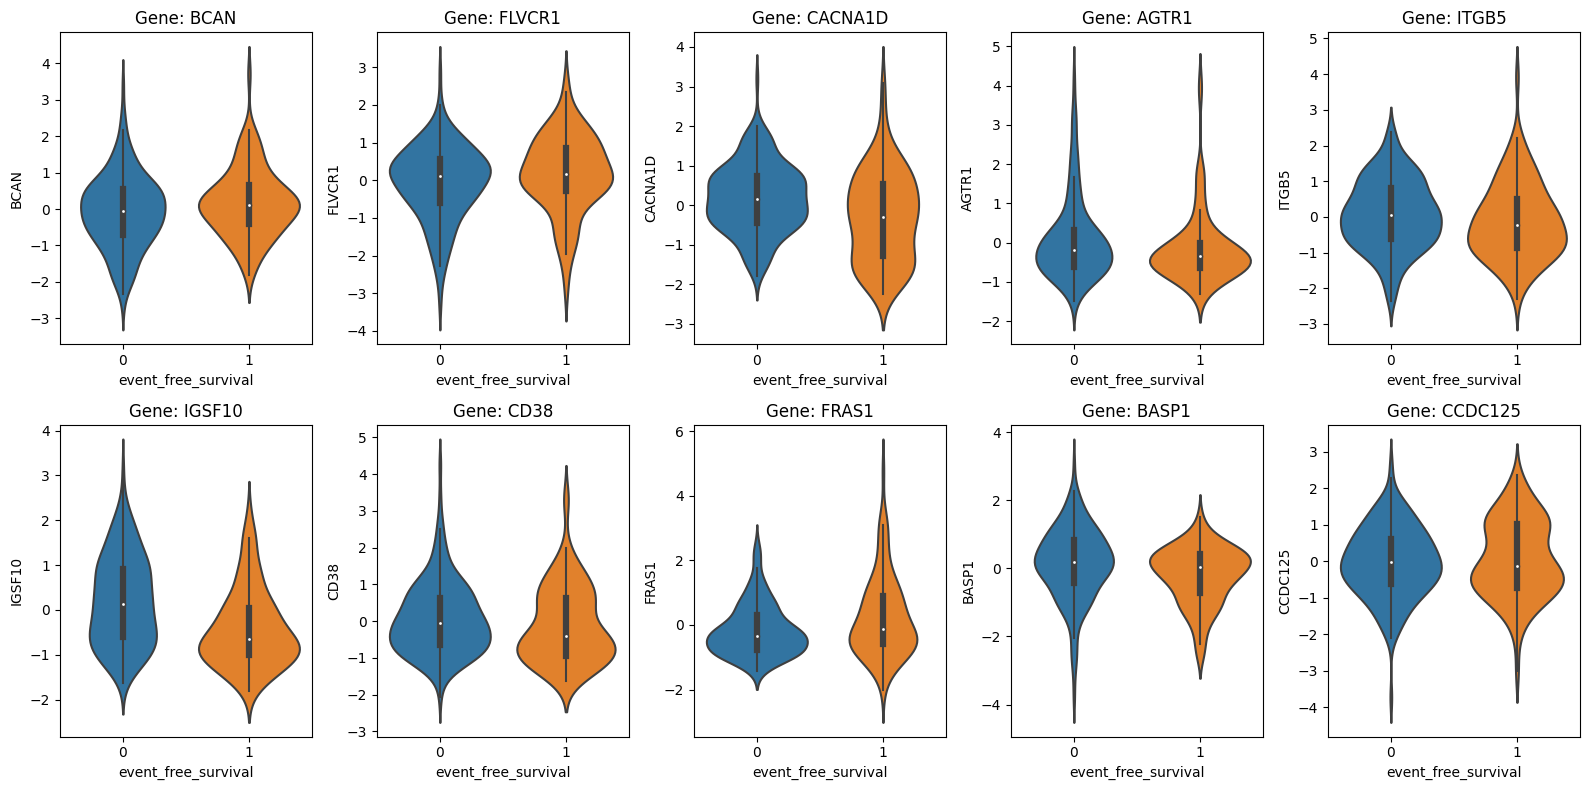

In [9]:
plt.figure(figsize=(16, 8))
for i, gene in enumerate(top_genes):
    plt.subplot(2, 5, i+1)
    sns.violinplot(x=train_clinical_df['event_free_survival'], y=train_genes_df[gene])
    plt.title(f'Gene: {gene}')

plt.tight_layout()
plt.show()

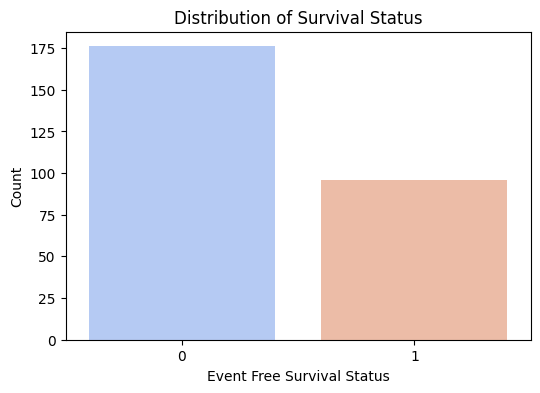

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

# Standardize the gene expression data for PCA and heatmap purposes
scaler = StandardScaler()
scaled_train_genes = scaler.fit_transform(train_genes_df)

# Ensure scaling is reflected in DataFrame
scaled_train_genes_df = pd.DataFrame(scaled_train_genes, columns=train_genes_df.columns)

# ---------------------- Class Imbalance Plot ----------------------

plt.figure(figsize=(6, 4))
sns.countplot(x=train_labels, palette='coolwarm')
plt.title('Distribution of Survival Status')
plt.xlabel("Event Free Survival Status")
plt.ylabel("Count")
plt.show()

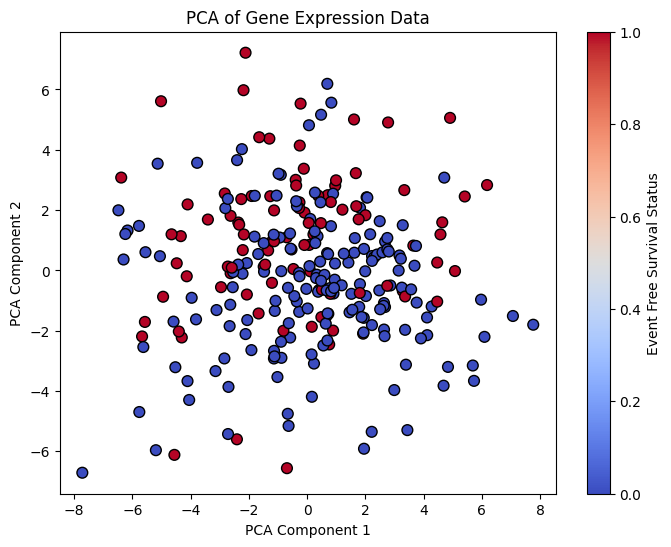

In [11]:
# ---------------------- PCA Visualization -------------------------

pca = PCA(n_components=2)  # We can visualize in 2 dimensions
pca_result = pca.fit_transform(scaled_train_genes)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, cmap='coolwarm', edgecolor='k', s=60)
plt.title('PCA of Gene Expression Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Event Free Survival Status')
plt.show()

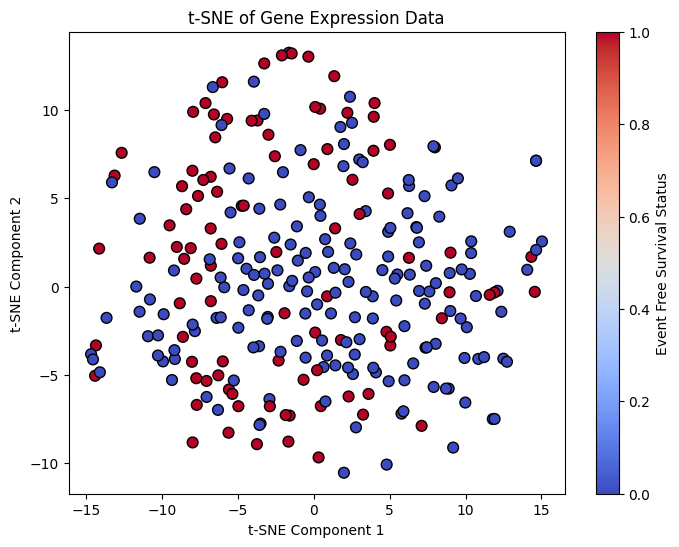

In [12]:
# ---------------------- t-SNE Visualization -----------------------

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_train_genes)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=train_labels, cmap='coolwarm', edgecolor='k', s=60)
plt.title('t-SNE of Gene Expression Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Event Free Survival Status')
plt.show()

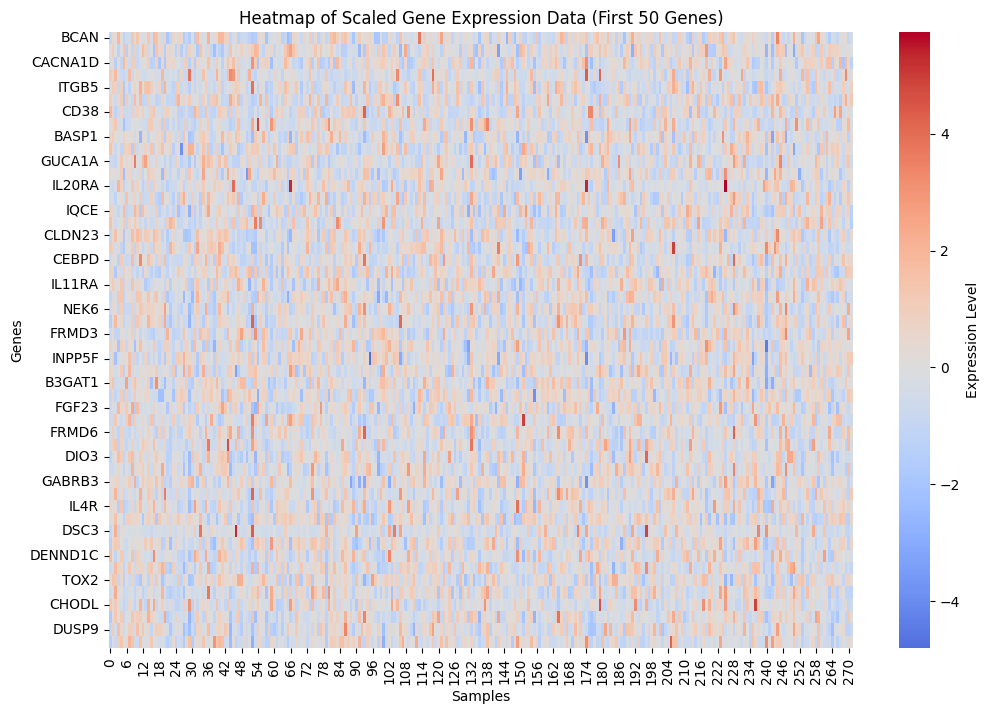

In [13]:
# ---------------------- Heatmap for Gene Expression ------------------

plt.figure(figsize=(12, 8))
sns.heatmap(scaled_train_genes_df.iloc[:, :50].T, cmap="coolwarm", cbar_kws={'label': 'Expression Level'}, center=0)
plt.title("Heatmap of Scaled Gene Expression Data (First 50 Genes)")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()

c:\Users\Advaitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

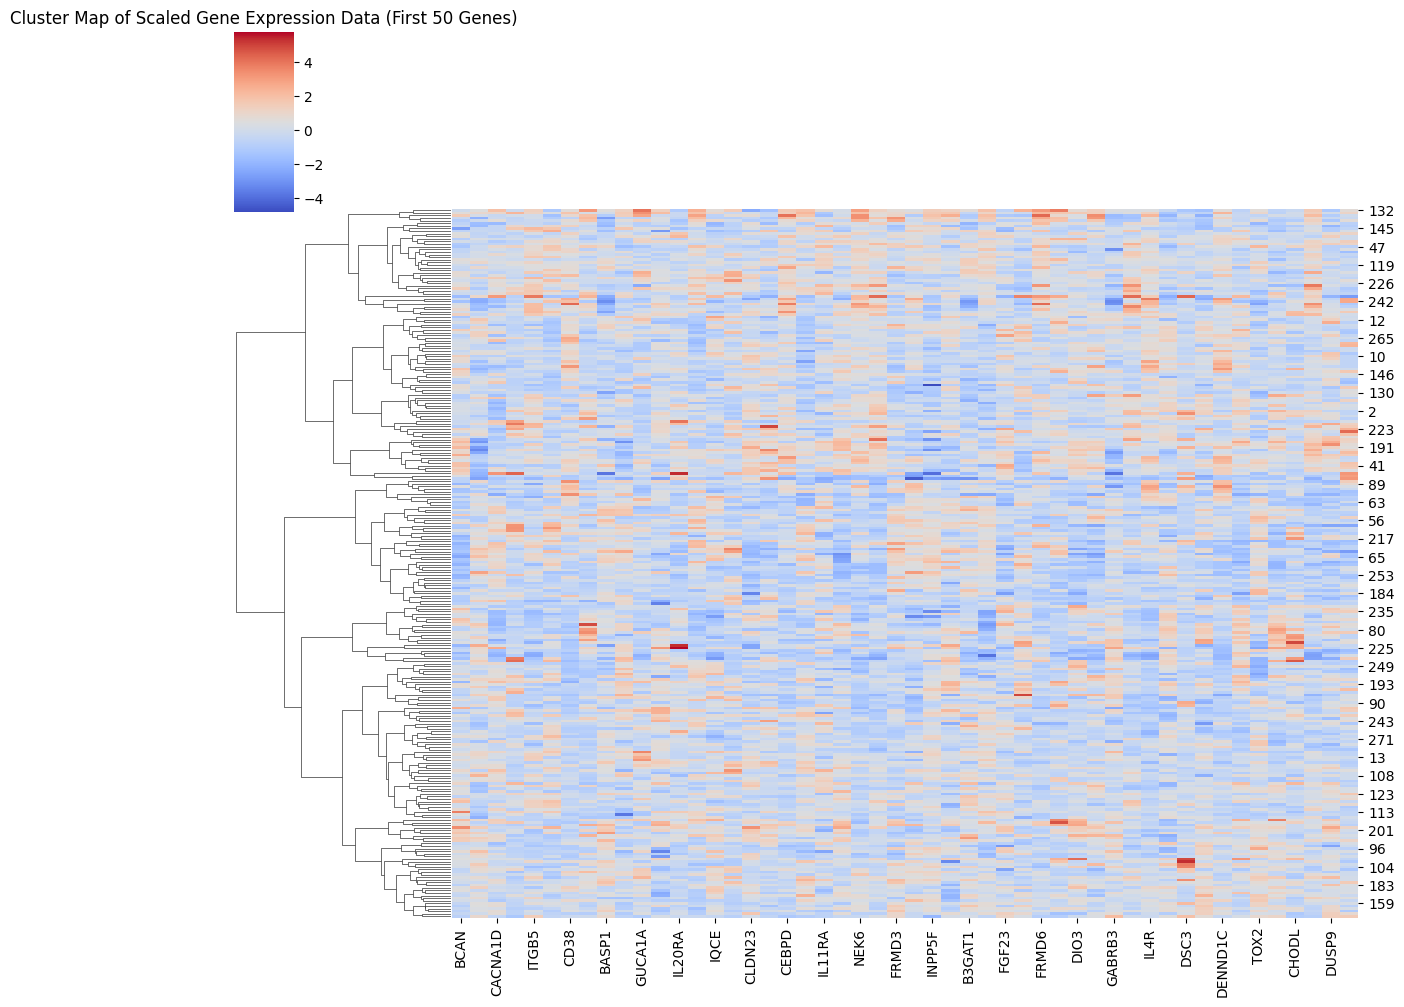

In [14]:
# ---------------------- Cluster Map for Gene Expression ------------------

plt.figure(figsize=(10, 10))
sns.clustermap(scaled_train_genes_df.iloc[:, :50], cmap="coolwarm", method='ward', metric='euclidean', figsize=(12, 10), col_cluster=False)
plt.title("Cluster Map of Scaled Gene Expression Data (First 50 Genes)")
plt.show()

# **Data Augmentation using SMOTE**

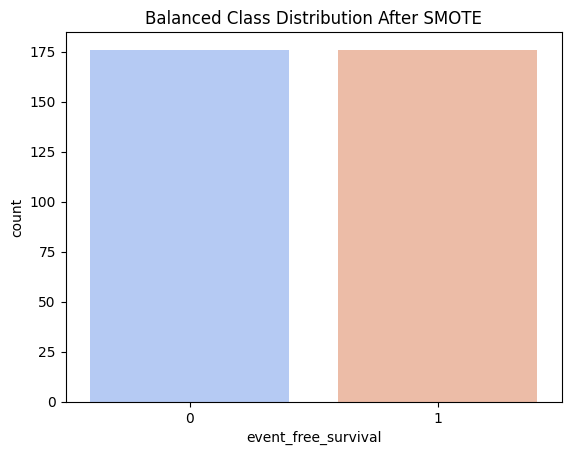

In [16]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_genes, train_labels)
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title('Balanced Class Distribution After SMOTE')
plt.show()

# **Differential Gene Expression Analysis**

In [18]:
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
def differential_expression(group_0, group_1):
    p_values, log_fold_changes = [], []

    for gene in train_genes_df.columns:
        t_stat, p_val = ttest_ind(group_0[gene], group_1[gene], nan_policy='omit')
        p_values.append(p_val)
        mean_0, mean_1 = group_0[gene].mean(), group_1[gene].mean()
        log_fold_changes.append(np.log2((mean_1 + 1) / (mean_0 + 1)))

    return pd.DataFrame({
        'Gene': train_genes_df.columns,
        'p_value': p_values,
        'log2_fold_change': log_fold_changes
    })

# Separate genes based on event_free_survival (0 = Non-survivors, 1 = Survivors)
group_0 = train_genes_df[train_clinical_df['event_free_survival'] == 0]
group_1 = train_genes_df[train_clinical_df['event_free_survival'] == 1]

dge_results = differential_expression(group_0, group_1)

_, p_adj, _, _ = multipletests(dge_results['p_value'], method='fdr_bh')
dge_results['adjusted_p_value'] = p_adj

significant_genes = dge_results[(dge_results['adjusted_p_value'] < 0.05) &
                                (np.abs(dge_results['log2_fold_change']) > 1)]

significant_genes = significant_genes.sort_values(by='adjusted_p_value')

print("Top Differentially Expressed Genes:")
print(significant_genes.head())

Top Differentially Expressed Genes:
      Gene       p_value  log2_fold_change  adjusted_p_value
29     CD9  3.451148e-11         -1.424401      1.829108e-09
19   KCNQ3  7.974318e-08         -1.135475      1.408796e-06
5   IGSF10  4.665723e-07         -1.049932      4.945667e-06


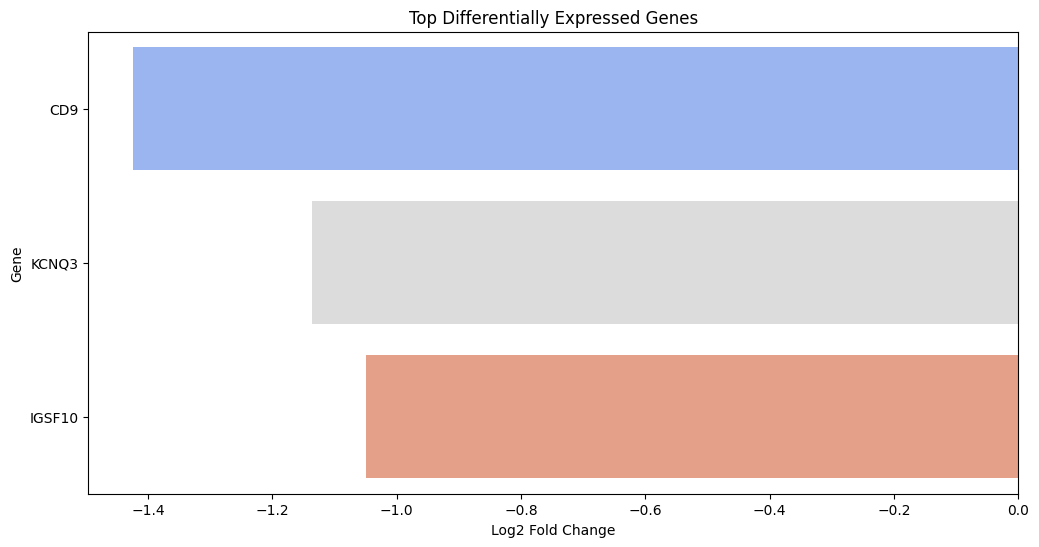

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x='log2_fold_change', y='Gene', data=significant_genes.head(10), palette='coolwarm')
plt.title('Top Differentially Expressed Genes')
plt.xlabel('Log2 Fold Change')
plt.ylabel('Gene')
plt.show()

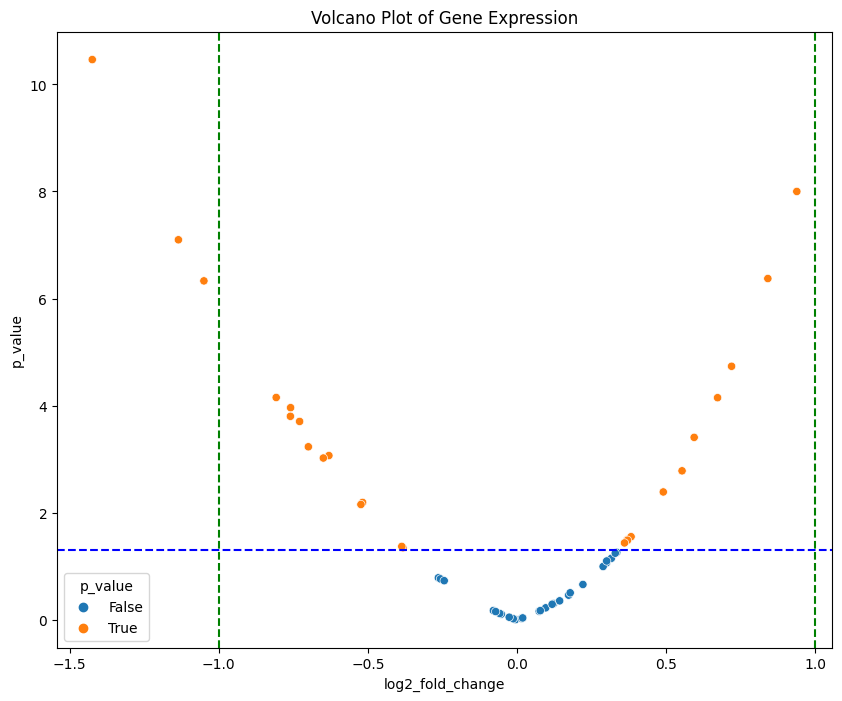

In [20]:
# Volcano Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=dge_results['log2_fold_change'], y=-np.log10(dge_results['p_value']), hue=dge_results['p_value'] < 0.05)
plt.title('Volcano Plot of Gene Expression')
plt.axhline(-np.log10(0.05), linestyle='--', color='blue')
plt.axvline(1, linestyle='--', color='green')
plt.axvline(-1, linestyle='--', color='green')
plt.show()

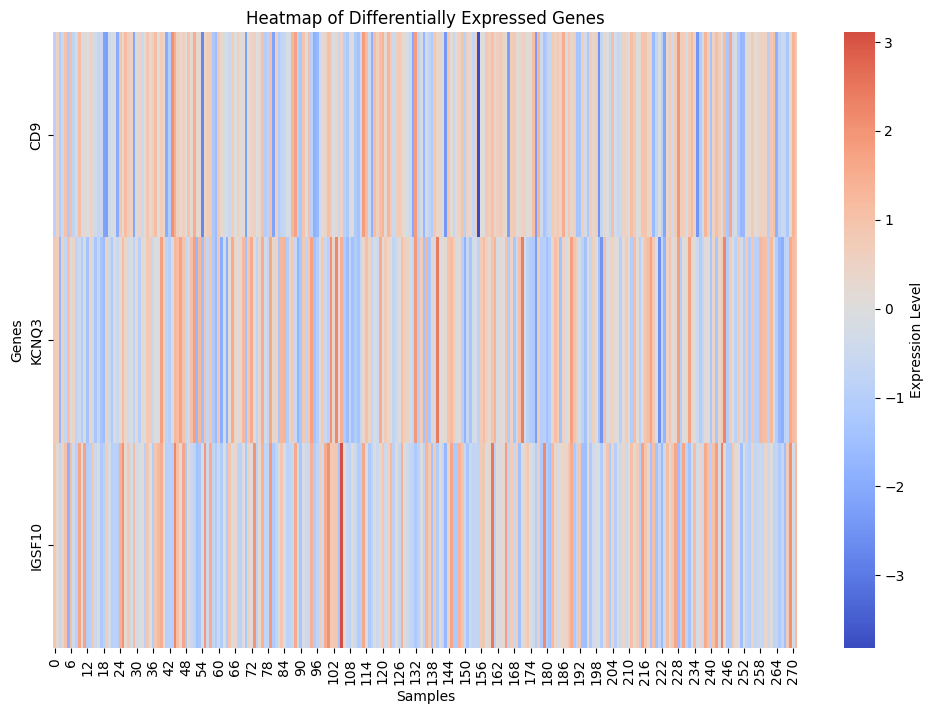

In [21]:
top_genes = significant_genes['Gene'].head(20)
top_genes_data = train_genes_df[top_genes]
plt.figure(figsize=(12, 8))
sns.heatmap(top_genes_data.T, cmap='coolwarm', cbar_kws={'label': 'Expression Level'}, center=0)
plt.title("Heatmap of Differentially Expressed Genes")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()

# **MODEL**

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
import shap

# Splitting the dataset into train and test (using your train and test data)
X_train = train_preprocessed.drop(columns=['event_free_survival'])
y_train = train_preprocessed['event_free_survival']

X_test = test_preprocessed.drop(columns=['event_free_survival'])
y_test = test_preprocessed['event_free_survival']

# Feature Selection using RandomForestClassifier
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)

# Selecting important features
X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)

# Random Forest Classifier with K-fold Cross Validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation score
cv_scores = cross_val_score(rf_model, X_train_sel, y_train, cv=kf, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy: {cv_scores.mean()}")

# Train the model
rf_model.fit(X_train_sel, y_train)
y_pred_rf = rf_model.predict(X_test_sel)

# Performance Metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Random Forest Cross-Validation Accuracy: 0.837912457912458
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        96

   micro avg       1.00      1.00      1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192
 samples avg       0.35      0.35      0.35       192



c:\Users\Advaitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Advaitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
train_data_path = r"C:\Users\Advaitha\Desktop\projects\GENOME\newmodel\GSE85047.csv"
test_data_path = r"C:\Users\Advaitha\Desktop\projects\GENOME\newmodel\test_GSE85047.csv"

train_df = pd.read_csv(train_data_path).drop(columns=['geo_id', 'sequence_id'], errors='ignore')
test_df = pd.read_csv(test_data_path).drop(columns=['geo_id', 'sequence_id'], errors='ignore')

clinical_features = ['age_at_diagnosis_days', 'mycn_amplification', 'event_free_survival',
                     'event_free_survival_days', 'inss_stage_2', 'inss_stage_3',
                     'inss_stage_4', 'inss_stage_4S']

gene_columns = [col for col in train_df.columns if col not in clinical_features]

train_clinical, train_genes = train_df[clinical_features], train_df[gene_columns]
test_clinical, test_genes = test_df[clinical_features], test_df[gene_columns]

train_labels, test_labels = train_df['event_free_survival'], test_df['event_free_survival']

scaler = StandardScaler()
train_genes_scaled = scaler.fit_transform(train_genes)
test_genes_scaled = scaler.transform(test_genes)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_genes_scaled, train_labels)

In [118]:
print("Train Clinical Shape:", train_clinical.shape)
print("Train Genes Shape:", train_genes.shape)
print("Train indices:", train_idx[:10])
print("Validation indices:", val_idx[:10])

Train Clinical Shape: (272, 8)
Train Genes Shape: (272, 53)
Train indices: [ 0  1  2  3  4  5  6  7  9 10]
Validation indices: [ 8 13 14 17 20 21 48 50 54 57]


In [119]:
print(train_clinical.iloc[:10].head())  
print(train_genes.iloc[:10].head())     

   age_at_diagnosis_days  mycn_amplification  event_free_survival  \
0                   7100                   0                    0   
1                    196                   0                    0   
2                    447                   1                    1   
3                      5                   0                    1   
4                    900                   0                    0   

   event_free_survival_days  inss_stage_2  inss_stage_3  inss_stage_4  \
0                      1357             0             1             0   
1                      2313             1             0             0   
2                      1198             0             0             1   
3                        67             1             0             0   
4                      2461             0             0             1   

   inss_stage_4S  
0              0  
1              0  
2              0  
3              0  
4              0  
       BCAN    FLVCR1   CACNA1D 

In [120]:
def build_enhanced_hybrid_model(input_dim_genes, input_dim_clinical):
    gene_input = Input(shape=(input_dim_genes,), name="gene_input")
    gene_dense = Dense(256, activation='relu')(gene_input)
    gene_dense = BatchNormalization()(gene_dense)
    gene_dense = Dropout(0.4)(gene_dense)
    gene_dense = Dense(128, activation='relu')(gene_dense)
    gene_dense = Dropout(0.4)(gene_dense)

    clinical_input = Input(shape=(input_dim_clinical,), name="clinical_input")
    clinical_dense = Dense(128, activation='relu')(clinical_input)
    clinical_dense = BatchNormalization()(clinical_dense)
    clinical_dense = Dropout(0.4)(clinical_dense)
    clinical_dense = Dense(64, activation='relu')(clinical_dense)
    clinical_dense = Dropout(0.4)(clinical_dense)

    combined = Concatenate()([gene_dense, clinical_dense])
    combined_dense = Dense(128, activation='relu')(combined)
    combined_dense = BatchNormalization()(combined_dense)
    combined_dense = Dropout(0.4)(combined_dense)
    combined_dense = Dense(64, activation='relu')(combined_dense)
    combined_dense = Dropout(0.4)(combined_dense)

    output = Dense(1, activation='sigmoid', name="output")(combined_dense)

    model = Model(inputs=[gene_input, clinical_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_enhanced_hybrid_model(input_dim_genes=train_genes.shape[1], input_dim_clinical=train_clinical.shape[1])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_genes)):
    X_train_genes = train_genes.iloc[train_idx].values
    X_val_genes = train_genes.iloc[val_idx].values
    y_train = y_resampled[train_idx]
    y_val = y_resampled[val_idx]
    try:
        clinical_train_data = train_clinical.iloc[train_idx].values
        clinical_val_data = train_clinical.iloc[val_idx].values
        print(f"Fold {fold} - Train Clinical Shape: {clinical_train_data.shape}")
        print(f"Fold {fold} - Validation Clinical Shape: {clinical_val_data.shape}")
        print(f"Fold {fold} - Train Genes Shape: {X_train_genes.shape}")
        print(f"Fold {fold} - Validation Genes Shape: {X_val_genes.shape}")
    except IndexError as e:
        print(f"IndexError in Fold {fold}: {e}")
        print(f"Train indices: {train_idx}")
        print(f"Validation indices: {val_idx}")
        continue

    model.fit([X_train_genes, clinical_train_data], y_train,
              validation_data=([X_val_genes, clinical_val_data], y_val),
              epochs=10, batch_size=32, verbose=1)

    val_pred = model.predict([X_val_genes, clinical_val_data])
    val_pred_class = (val_pred > 0.5).astype(int)

    print(f'Fold {fold} - Accuracy: {accuracy_score(y_val, val_pred_class)}')
    print(f'Fold {fold} - AUC: {roc_auc_score(y_val, val_pred)}')

test_predictions = model.predict([test_genes_scaled, test_clinical])
test_predictions_class = (test_predictions > 0.5).astype(int)

print(f'Test Accuracy: {accuracy_score(test_labels, test_predictions_class)}')
print(f'Test AUC: {roc_auc_score(test_labels, test_predictions)}')

Fold 0 - Train Clinical Shape: (217, 8)
Fold 0 - Validation Clinical Shape: (55, 8)
Fold 0 - Train Genes Shape: (217, 53)
Fold 0 - Validation Genes Shape: (55, 53)
Epoch 1/10
7/7 [==============================] - 5s 105ms/step - loss: 0.7195 - accuracy: 0.6037 - val_loss: 0.5118 - val_accuracy: 0.7455
Epoch 2/10
7/7 [==============================] - 0s 20ms/step - loss: 0.7573 - accuracy: 0.5945 - val_loss: 0.5004 - val_accuracy: 0.6909
Epoch 3/10
7/7 [==============================] - 0s 24ms/step - loss: 0.5140 - accuracy: 0.7097 - val_loss: 0.4938 - val_accuracy: 0.8000
Epoch 4/10
7/7 [==============================] - 0s 22ms/step - loss: 0.5877 - accuracy: 0.7005 - val_loss: 0.4935 - val_accuracy: 0.8000
Epoch 5/10
7/7 [==============================] - 0s 18ms/step - loss: 0.5314 - accuracy: 0.7604 - val_loss: 0.4881 - val_accuracy: 0.7636
Epoch 6/10
7/7 [==============================] - 0s 18ms/step - loss: 0.5733 - accuracy: 0.7051 - val_loss: 0.4816 - val_accuracy: 0.7636
E

In [121]:
history_per_fold = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_genes)):
    # (code to get training and validation data)
    
    # Train the model and store the history
    history = model.fit([X_train_genes, clinical_train_data], y_train,
                        validation_data=([X_val_genes, clinical_val_data], y_val),
                        epochs=10, batch_size=32, verbose=1)
    
    # Append history to the list
    history_per_fold.append(history.history)

Epoch 1/10
7/7 [==============================] - 0s 25ms/step - loss: 0.1976 - accuracy: 0.9128 - val_loss: 0.0612 - val_accuracy: 0.9815
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 0.1722 - accuracy: 0.9266 - val_loss: 0.0636 - val_accuracy: 0.9815
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 0.1262 - accuracy: 0.9587 - val_loss: 0.0657 - val_accuracy: 0.9815
Epoch 4/10
7/7 [==============================] - 0s 14ms/step - loss: 0.1060 - accuracy: 0.9679 - val_loss: 0.0704 - val_accuracy: 0.9815
Epoch 5/10
7/7 [==============================] - 0s 9ms/step - loss: 0.1402 - accuracy: 0.9541 - val_loss: 0.0727 - val_accuracy: 0.9815
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 0.1534 - accuracy: 0.9450 - val_loss: 0.0741 - val_accuracy: 0.9815
Epoch 7/10
7/7 [==============================] - 0s 9ms/step - loss: 0.1645 - accuracy: 0.9358 - val_loss: 0.0792 - val_accuracy: 0.9815
Epoch 8/10
7/7 [=============

KeyboardInterrupt: 

In [122]:
import matplotlib.pyplot as plt

Training and Validation Accuracy for each epoch

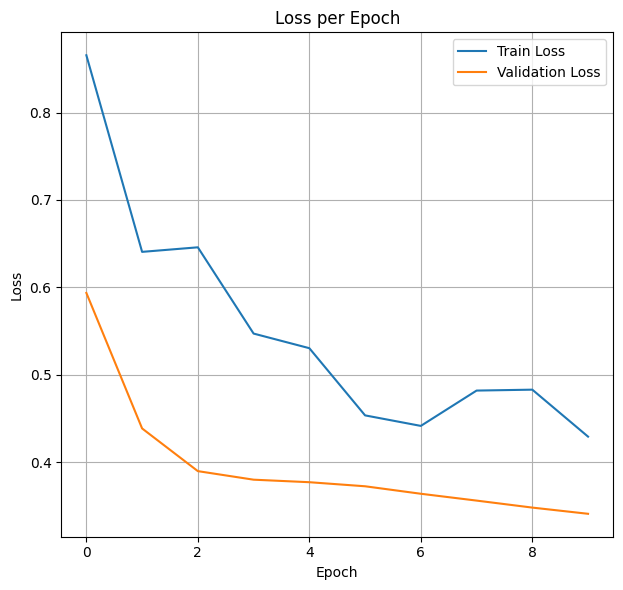

In [78]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
from sklearn.metrics import f1_score

# Assuming `test_labels` and `test_predictions_class` are defined
f1 = f1_score(test_labels, test_predictions_class)
print(f'F1 Score: {f1}')


F1 Score: 0.9894736842105264


In [126]:
from sklearn.metrics import log_loss

# Assuming `test_labels` are the true labels (0 or 1)
# And `test_predictions` are the predicted probabilities from the model (between 0 and 1)
log_loss_value = log_loss(test_labels, test_predictions)
print(f'Log Loss: {log_loss_value}')


Log Loss: 0.06303580962059074


In [130]:
from sklearn.metrics import precision_score, recall_score

# After training, extract metrics from the history object:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the final epoch's results:
print(f"Final Training Accuracy: {train_acc[-1]}")
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Validation Accuracy: {val_acc[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")

# Get predictions for the validation set
val_predictions = model.predict([X_val_genes, clinical_val_data])
val_predictions_class = (val_predictions > 0.5).astype(int)  # Convert to binary predictions

# Calculate precision and recall for the validation set
precision_val = precision_score(y_val, val_predictions_class)
recall_val = recall_score(y_val, val_predictions_class)

# Print the precision and recall for validation set
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

# If you want to calculate precision and recall on the training set too:
train_predictions = model.predict([X_train_genes, clinical_train_data])
train_predictions_class = (train_predictions > 0.5).astype(int)

precision_train = precision_score(y_train, train_predictions_class)
recall_train = recall_score(y_train, train_predictions_class)


# Print the precision and recall for training set
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")



Final Training Accuracy: 0.9678899049758911
Final Training Loss: 0.08244069665670395
Final Validation Accuracy: 0.9814814925193787
Final Validation Loss: 0.09862352907657623
2/2 [==============================] - 0s 0s/step
Validation Precision: 0.9473684210526315
Validation Recall: 0.9473684210526315
7/7 [==============================] - 0s 2ms/step
Training Precision: 1.0
Training Recall: 1.0


In [136]:
test_predictions = model.predict([test_genes_scaled, test_clinical])
test_predictions_class = (test_predictions > 0.5).astype(int)

9/9 [==============================] - 0s 2ms/step


In [139]:
precision_test = recall_score(test_labels, test_predictions_class)
print(f"Test Precision: {precision_test}")

Test Precision: 0.9895833333333334


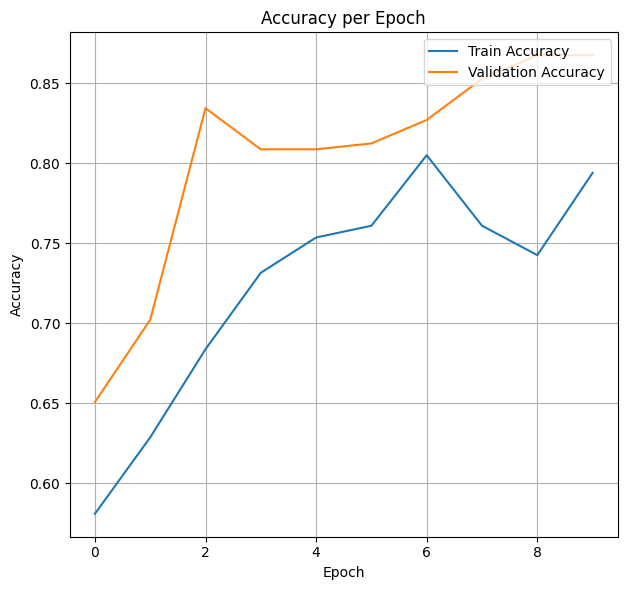

In [79]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


ROC CURVE FOR VALIDATION AND TESTING


2/2 [==============================] - 0s 0s/step


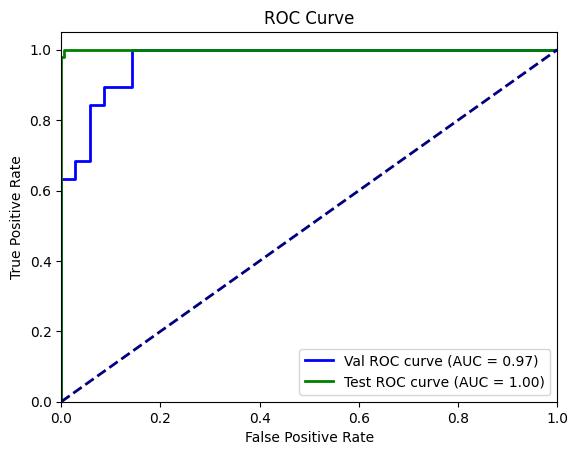

In [50]:
from sklearn.metrics import roc_curve, auc

val_pred = model.predict([X_val_genes, clinical_val_data])
fpr_val, tpr_val, _ = roc_curve(y_val, val_pred)
roc_auc_val = auc(fpr_val, tpr_val)
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure()
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Val ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


CMS


9/9 [==============================] - 0s 2ms/step


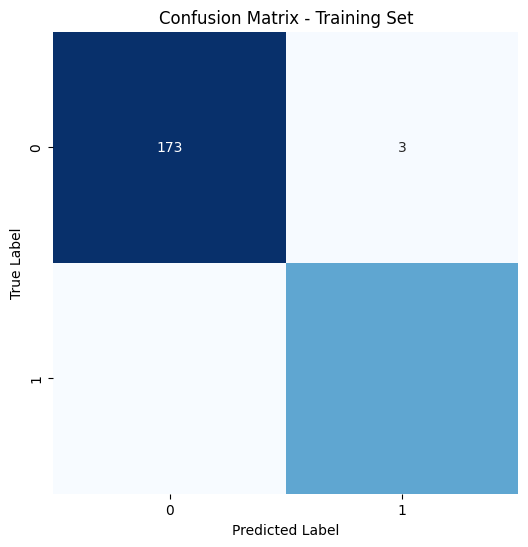

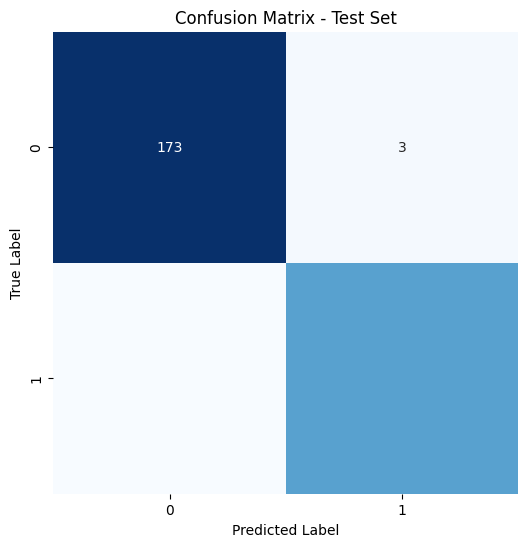

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
train_predictions = model.predict([train_genes_scaled, train_clinical])
train_predictions_class = (train_predictions > 0.5).astype(int)


cm_train = confusion_matrix(train_labels, train_predictions_class)


plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



cm_test = confusion_matrix(test_labels, test_predictions_class)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


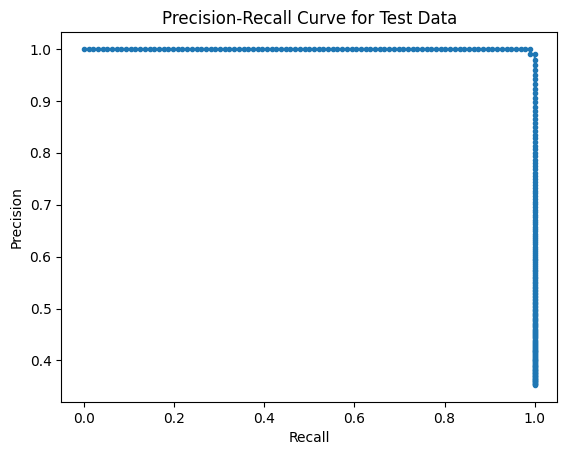

In [124]:
from sklearn.metrics import precision_recall_curve


precision, recall, _ = precision_recall_curve(test_labels, test_predictions)


plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Test Data')
plt.show()

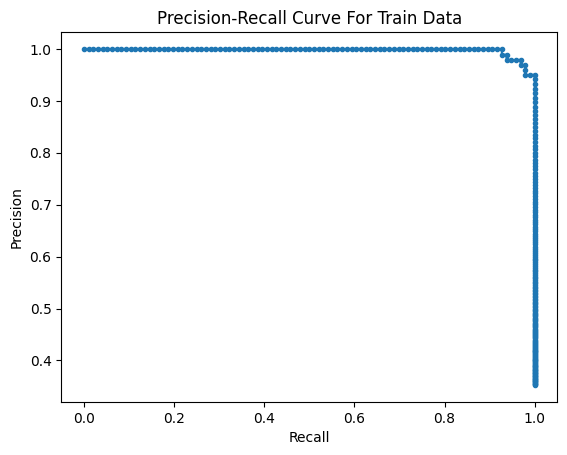

In [114]:
from sklearn.metrics import precision_recall_curve


precision, recall, _ = precision_recall_curve(train_labels, train_predictions)


plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve For Train Data')
plt.show()

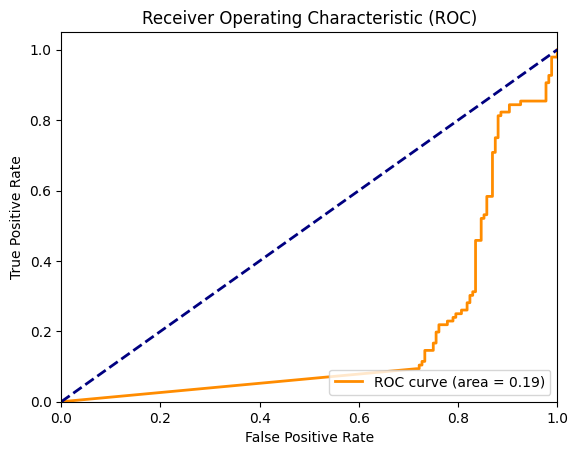

In [81]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


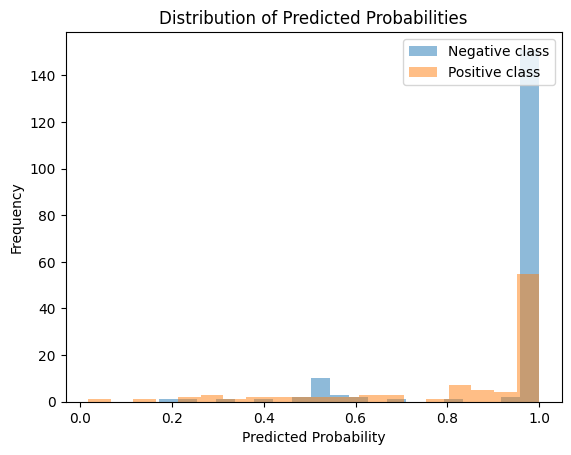

In [83]:
plt.figure()
plt.hist(test_predictions[test_labels == 0], bins=20, alpha=0.5, label='Negative class')
plt.hist(test_predictions[test_labels == 1], bins=20, alpha=0.5, label='Positive class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend(loc='upper right')
plt.show()


In [86]:
print(test_predictions.shape)  
print(test_labels.shape)       


(272, 1)
(272,)


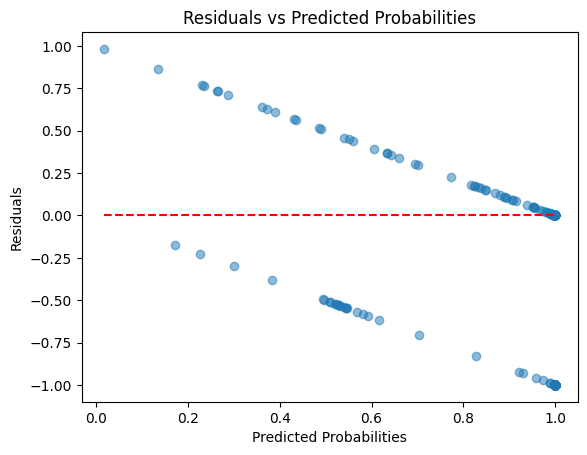

In [87]:
import numpy as np
import matplotlib.pyplot as plt
test_predictions_flat = np.ravel(test_predictions)
test_labels_flat = np.ravel(test_labels)
residuals = test_labels_flat - test_predictions_flat


plt.figure()
plt.scatter(test_predictions_flat, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(test_predictions_flat), xmax=max(test_predictions_flat), color='r', linestyle='--')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Probabilities')
plt.show()


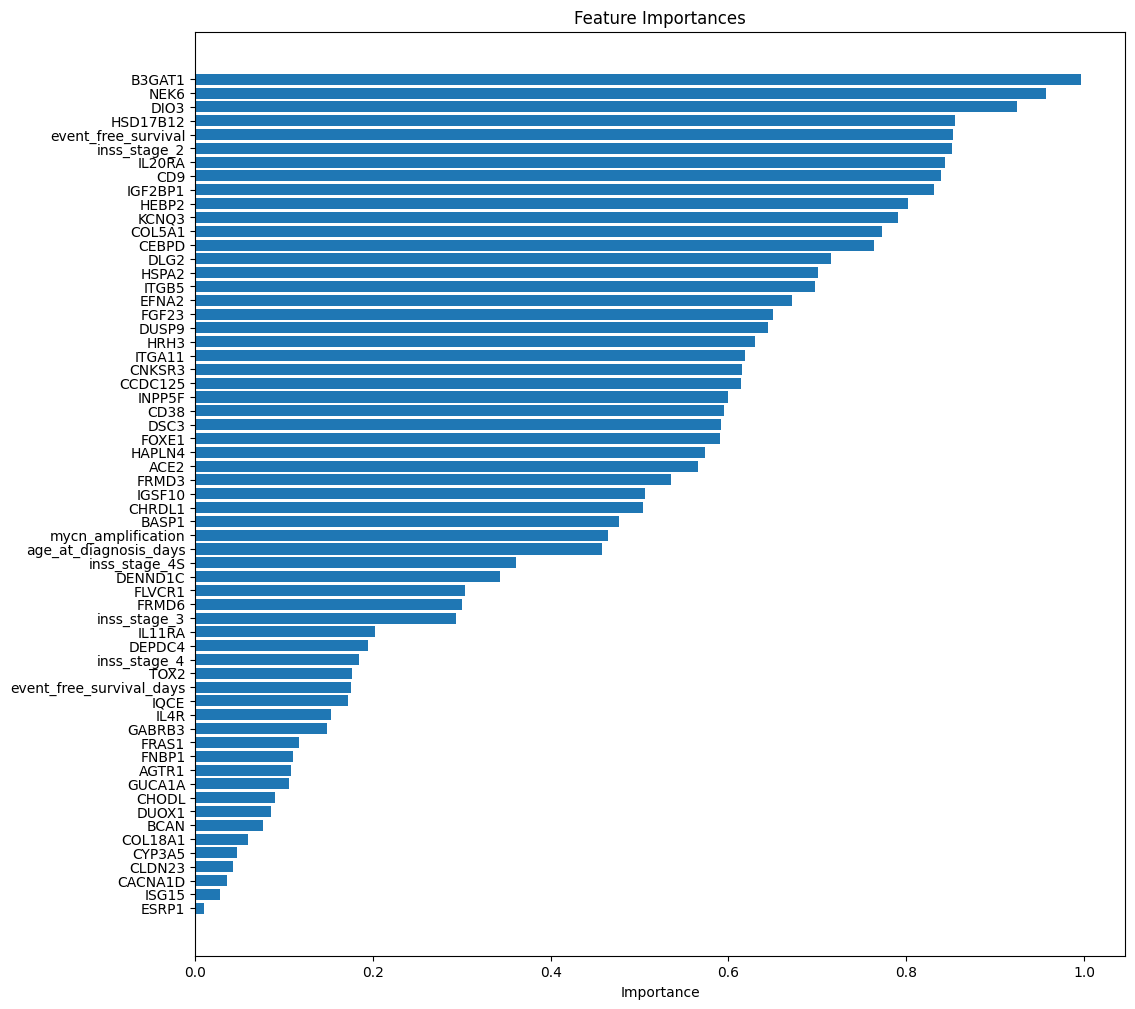

In [100]:
import numpy as np
import matplotlib.pyplot as plt


importances = np.random.rand(len(gene_columns + clinical_features))  
features = gene_columns + clinical_features


indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(features)[indices])
plt.xlabel('Importance')
plt.show()


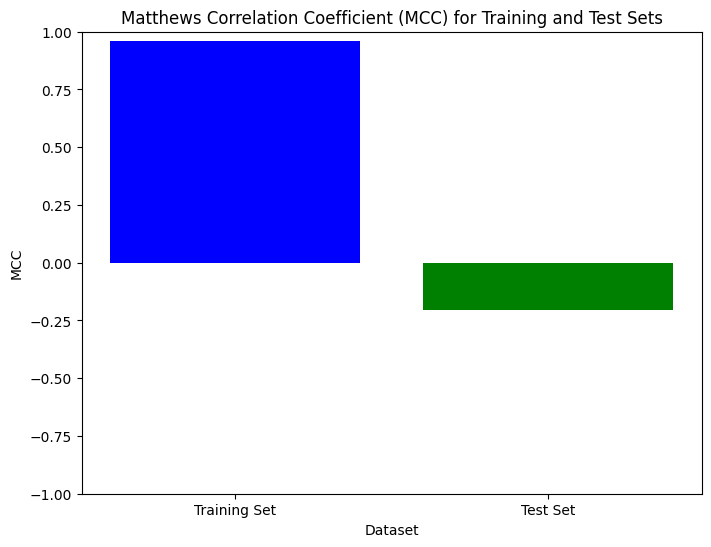

In [105]:
from sklearn.metrics import matthews_corrcoef


train_predictions_class = (train_predictions > 0.5).astype(int)
mcc_train = matthews_corrcoef(train_labels, train_predictions_class)

test_predictions_class = (test_predictions > 0.5).astype(int)
mcc_test = matthews_corrcoef(test_labels, test_predictions_class)


mcc_values = [mcc_train, mcc_test]
labels = ['Training Set', 'Test Set']

plt.figure(figsize=(8, 6))
plt.bar(labels, mcc_values, color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('MCC')
plt.title('Matthews Correlation Coefficient (MCC) for Training and Test Sets')
plt.ylim(-1, 1)
plt.show()


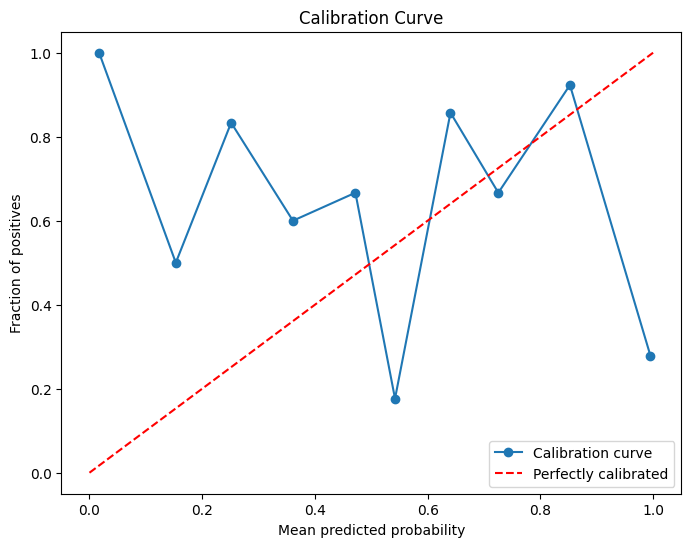

In [107]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(test_labels, test_predictions, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly calibrated')



plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.show()
